<a href="https://colab.research.google.com/github/bc2026/DenoisingSIAIML/blob/main/denosing_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np
import pandas as pd
!pip install opencv-python
import cv2
from PIL import Image

In [16]:
img = Image.open("/content/drive/MyDrive/Prof._Lee_Research/Streams/Cell1_S1.tif")

path_to_csv = '/content/drive/MyDrive/Prof._Lee_Research/Streams/ParticleLocalization/p1c1s1_11/p1c1s1_11.csv'

In [17]:
# Read all frames and convert to grayscale
frames = []
for i in range(img.n_frames):
    img.seek(i)  # Move to frame i
    gray_frame = img.convert("L")  # Convert to grayscale
    frames.append(np.array(gray_frame))

In [18]:
# Normalize by 255
frames = np.divide(frames, 255.0)

In [19]:
frames[0] # Access first image
frames[0][0] # Access first row of first image
frames[0][0][0] # Access first pixel

np.float64(1.0)

In [20]:
from sklearn.model_selection import train_test_split
start_X, start_Y = 439, 280

In [21]:
def generate_mask_from_csv(csv_path, image_shape, particle_radius=20):
    """
    Generate a binary mask from particle coordinates in a CSV file

    Parameters:
    - csv_path: Path to CSV file with particle locations
    - image_shape: Shape of the image (height, width)
    - particle_radius: Radius of particles in pixels

    Returns:
    - Binary mask with particles marked as 1
    """
    # Read CSV file
    df = pd.read_csv(csv_path)

    # Create empty mask
    mask = np.zeros(image_shape, dtype=np.float32)

    # For each particle, mark its location in the mask
    for _, row in df.iterrows():
        x, y = int(row['centroidGlobalColX']), int(row['centroidGlobalRowY'])

        # Create a circle for each particle
        y_indices, x_indices = np.ogrid[:image_shape[0], :image_shape[1]]
        dist = np.sqrt((y_indices - y)**2 + (x_indices - x)**2)
        circle = dist <= particle_radius
        mask[circle] = 1.0

    return mask

In [22]:
masks = generate_mask_from_csv(path_to_csv, frames.shape)

In [23]:
coordinates = pd.read_csv(path_to_csv)
coordinates = coordinates / 1023
coordinates

,centroidGlobalColX,centroidGlobalRowY
0,0.431085,0.275660
1,0.431085,0.275660
2,0.431085,0.275660
3,0.431085,0.275660
4,0.431085,0.280547
...,...,...
296,0.434018,0.286413
297,0.435973,0.286413
298,0.434018,0.290323
299,0.434018,0.290323


In [24]:
X_train, X_test, y_train, y_test = train_test_split(frames, coordinates, test_size=0.1, random_state=1)

In [32]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Assuming your input is a sequence of image frames
# And your output is the (x, y) coordinates of the particle
input_shape = (1024, 1024, 1)  # Example: 64x64 grayscale images
# For an MLP approach
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)  # Output (x, y) coordinates
])

# Compile with appropriate loss for regression
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error as a readable metric
)


# Train the model
model.fit(X_train, coordinates, epochs=10, batch_size=32, validation_split=0.1)


# predictions = model.predict(frames) * 1023.0


In [29]:
model.save('particle_tracker_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


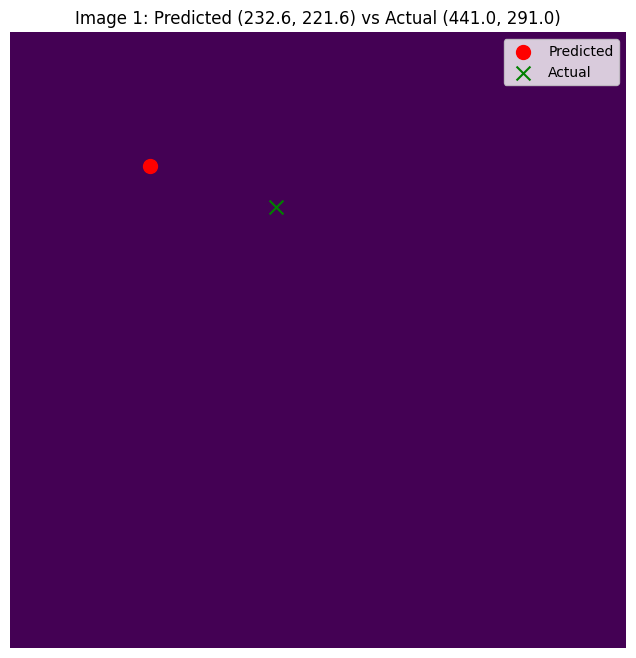

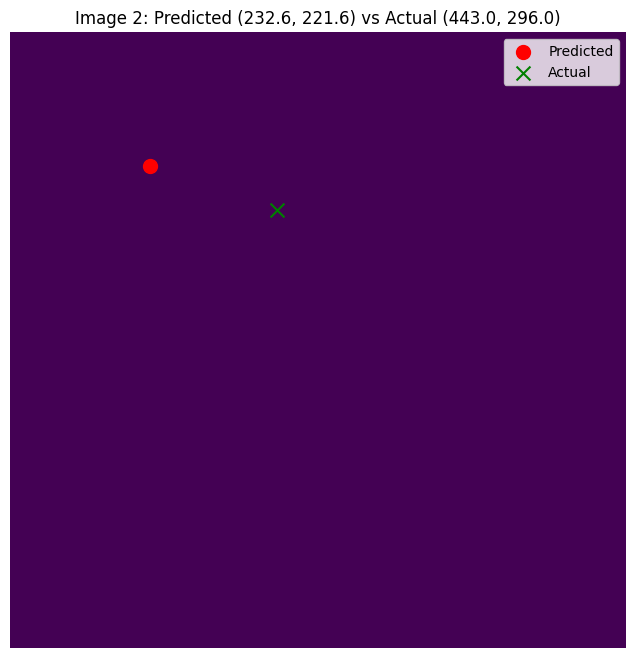

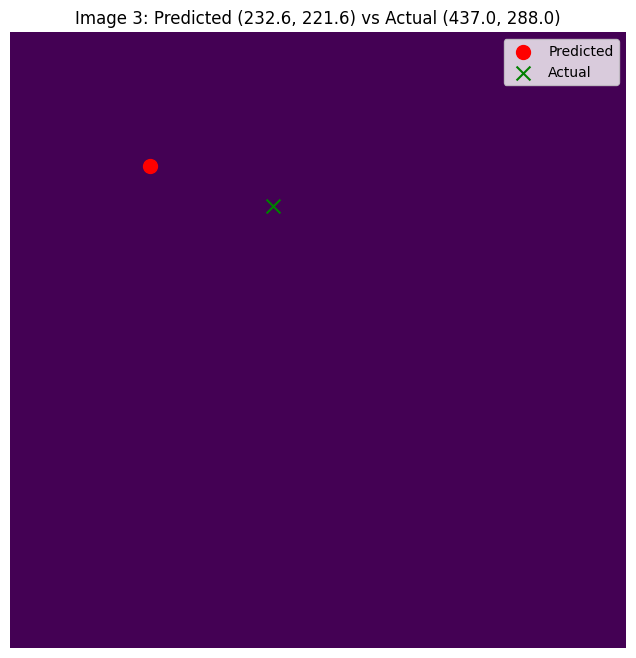

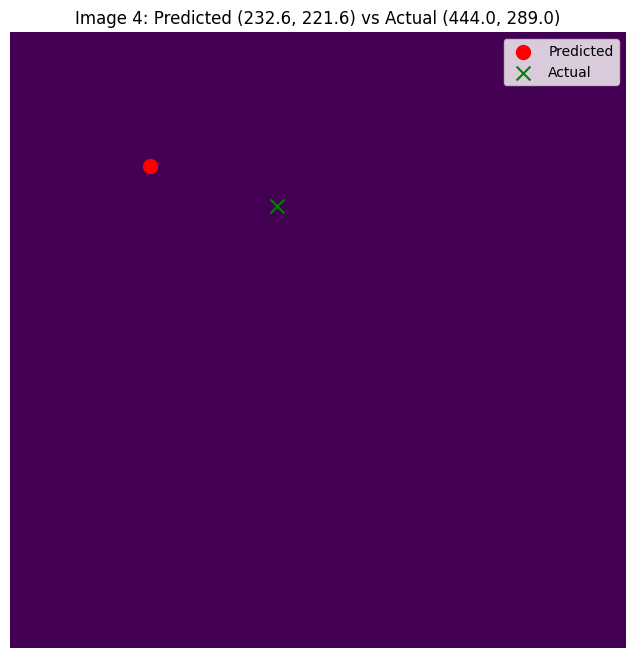

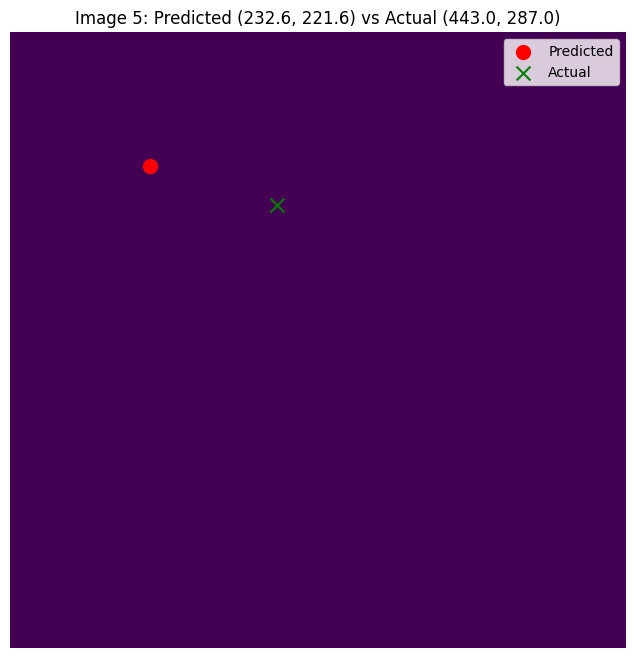

In [41]:
# model = load_model("/content/particle_tracker_model.keras")
# Predict coordinates (normalized, then scaled back to pixels)

predictions = model.predict(X_test) * 1023.0
y_test_pixels = y_test  # Assuming y_test is already in pixels; if not, multiply by 1023.0
x_coords, y_coords = y_test_pixels["centroidGlobalColX"], y_test_pixels["centroidGlobalRowY"]

x_coords = x_coords * 1023.0
y_coords = y_coords * 1023.0

# Visualize predictions vs. ground truth
for i in range(min(5, len(X_test))):  # Show up to 5 examples
    plt.figure(figsize=(8, 8))
    plt.imshow(X_test[i, :, :])  # Display grayscale image

    # Plot predicted coordinates (red dot)
    pred_x, pred_y = predictions[i]
    plt.scatter(pred_x, pred_y, c='red', s=100, label='Predicted', marker='o')

    # Plot actual coordinates (green dot)
    true_x, true_y = x_coords.iloc[i], y_coords.iloc[i]
    plt.scatter(true_x, true_y, c='green', s=100, label='Actual', marker='x')

    plt.title(f"Image {i+1}: Predicted ({pred_x:.1f}, {pred_y:.1f}) vs Actual ({true_x:.1f}, {true_y:.1f})")
    plt.legend()
    plt.axis('off')  # Hide axes for cleaner look
    plt.show()